In [9]:
# download the electrity demand data sector wise and run following to create normalized shape and then use the upper
# code to make heat demand

First is to make bell shaped yearly curves, 

In [4]:
#  Cooling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the new Excel file
file_path_cooling = 'data/heat_demand/residential/new_heating.xlsx'
cooling_data = pd.ExcelFile(file_path_cooling)

# Load the data from the first sheet
df_cooling = cooling_data.parse(cooling_data.sheet_names[0])

# Generate hourly timestamps for one year (2025)
timestamps = pd.date_range(start='2013-01-01', end='2013-12-31 23:00:00', freq='H')

# Create a DataFrame to hold these timestamps
df_yearly = pd.DataFrame({'timestamp': timestamps})

# Determine day_type based on the day of the week
# 0 = weekday (Monday to Friday), 1 = Saturday, 2 = Sunday
df_yearly['day_of_week'] = df_yearly['timestamp'].dt.dayofweek
df_yearly['day_type'] = df_yearly['day_of_week'].apply(lambda x: 0 if x < 5 else (1 if x == 5 else 2))

# Assign hour (1-24)
df_yearly['hour'] = df_yearly['timestamp'].dt.hour + 1

# Create a smooth bell-shaped temperature profile for 365 days
days_in_year = 365
day_of_year = np.arange(days_in_year)

# Generate a sine wave temperature curve (peak in mid-summer)
temperature_curve = np.sin((2 * np.pi / days_in_year) * (day_of_year - days_in_year / 4))

# Scale to the desired temperature range (19°C to 40°C)
min_temp = -15
max_temp = 17
scaled_temperatures = (temperature_curve + 1) / 2 * (max_temp - min_temp) + min_temp

# Assign these temperatures to each hour of the year
df_yearly['temperature'] = np.repeat(scaled_temperatures, 24)
# Round temperature for merging with cooling profile (assumes cooling profiles have integer temperatures)
df_yearly['temperature_rounded'] = df_yearly['temperature'].round().astype(int)

# Merge with the original cooling data
df_final_corrected = pd.merge(
    df_yearly,
    df_cooling,
    left_on=['day_type', 'hour', 'temperature_rounded'],
    right_on=['day_type', 'hour', 'temperature'],
    how='left'
)

# Drop the extra columns for clarity
df_final_corrected.drop(columns=['temperature_rounded', 'day_of_week'], inplace=True)

# Save to an Excel file
output_file = 'data/heat_demand/residential/corrected_yearly_heating_profile.xlsx'
df_final_corrected.to_excel(output_file, index=False)


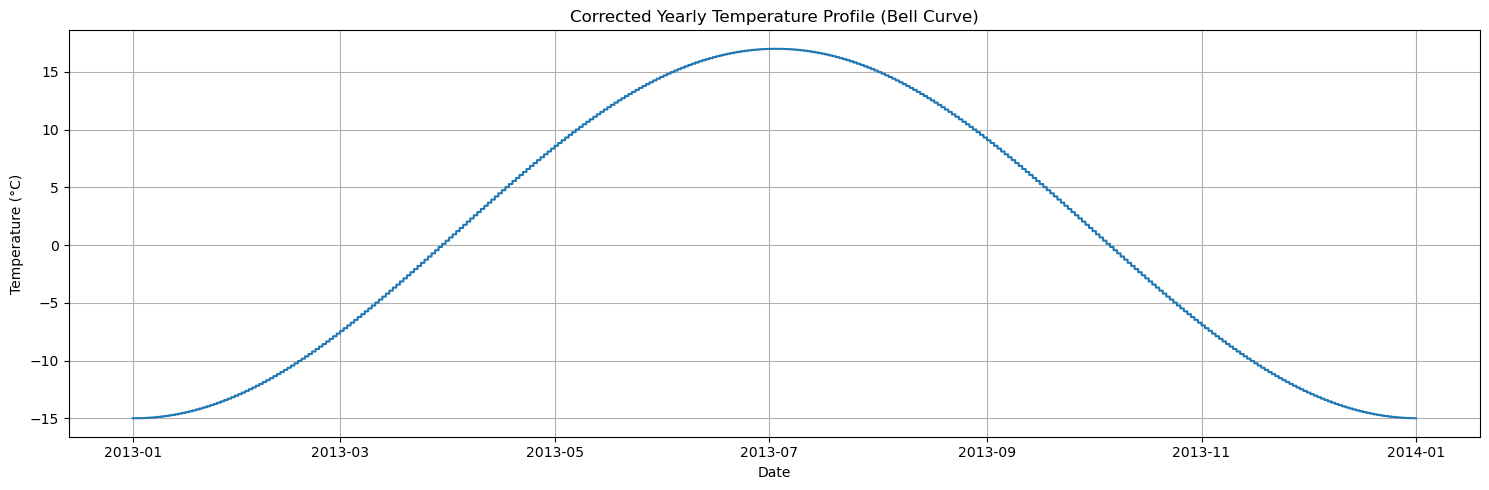

In [5]:

# Plot the corrected temperature profile
plt.figure(figsize=(15, 5))
plt.plot(df_yearly['timestamp'], df_yearly['temperature'])
plt.title('Corrected Yearly Temperature Profile (Bell Curve)')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.grid(True)
plt.tight_layout()
plt.show()



In [ ]:
# space and water
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the new Excel file
file_path_space_water = '/mnt/data/new_space_water.xlsx'
space_water_data = pd.ExcelFile(file_path_space_water)

# Load the data from the first sheet
df_space_water = space_water_data.parse(space_water_data.sheet_names[0])

# Calculate average load per season
average_load_per_season = df_space_water.groupby('season')['load'].mean()
print("Average Load per Season:\n", average_load_per_season)

# Determine mapping based on average load (manual step after viewing the print)
# Highest load → Winter (1), Lowest load → Summer (0), Middle → Transition (2)

# Generate hourly timestamps for one year (2013)
timestamps_2013 = pd.date_range(start='2013-01-01', end='2013-12-31 23:00:00', freq='H')

# Create a DataFrame to hold these timestamps
df_yearly_sw = pd.DataFrame({'timestamp': timestamps_2013})

# Determine month and day_type (weekdays=0, Saturday=1, Sunday=2)
df_yearly_sw['month'] = df_yearly_sw['timestamp'].dt.month
df_yearly_sw['day_of_week'] = df_yearly_sw['timestamp'].dt.dayofweek
df_yearly_sw['day_type'] = df_yearly_sw['day_of_week'].apply(lambda x: 0 if x < 5 else (1 if x == 5 else 2))

# Assign hour (1-24)
df_yearly_sw['hour'] = df_yearly_sw['timestamp'].dt.hour + 1

# Map months to seasons based on the derived mapping:
# Season 1 (Winter): Dec, Jan, Feb
# Season 2 (Transition): Mar-May, Sep-Nov
# Season 0 (Summer): Jun-Aug

def get_season(month):
    if month in [12, 1, 2]:
        return 1  # Winter
    elif month in [3, 4, 5, 9, 10, 11]:
        return 2  # Transition
    else:
        return 0  # Summer

df_yearly_sw['season'] = df_yearly_sw['month'].apply(get_season)

# Merge with the original space water heating profile based on day_type, hour, and season
df_final_sw = pd.merge(
    df_yearly_sw,
    df_space_water,
    on=['season', 'day_type', 'hour'],
    how='left'
)

# Drop unnecessary columns for clarity
df_final_sw.drop(columns=['day_of_week', 'month'], inplace=True)

# Save to an Excel file
output_file_sw_2013 = '/mnt/data/yearly_space_water_heating_profile_2013.xlsx'
df_final_sw.to_excel(output_file_sw_2013, index=False)

print(f"File saved to: {output_file_sw_2013}")


In [10]:
# summing the sector wise data from chemicals sheet:
# Prepare final table with all relevant heating-related values from chemical sub-sectors
chemical_heat_ktoe = {
    "Basic chemicals": 9409.7,
    "Other chemicals": 2045.2,
    "Pharmaceuticals": 1176.0
}

# Convert ktoe to TWh
chemical_heat_twh = {sector: ktoe * 0.01163 for sector, ktoe in chemical_heat_ktoe.items()}

# Combine into a DataFrame
df_chem_heat = pd.DataFrame({
    "Heat Demand (ktoe)": chemical_heat_ktoe,
    "Heat Demand (TWh)": chemical_heat_twh
})

# Save to CSV
csv_path = "data/heat_demand/industry/chemical_industry_heat_demand_2019.csv"
df_chem_heat.to_csv(csv_path)


In [11]:
## 
# Code for extracting heat demand from JRC idees sector and subsector wise 
# Define relevant FEC sheets and their descriptions
fec_sheets = {
    "ISI_fec": "Iron and Steel",
    "NFM_fec": "Non-Ferrous Metals",
    "CHI_fec": "Chemicals",
    "NMM_fec": "Non-Metallic Minerals",
    "PPA_fec": "Pulp, Paper, and Printing",
    "FBT_fec": "Food, Beverages, Tobacco",
    "TRE_fec": "Transport Equipment",
    "MAE_fec": "Machinery and Equipment",
    "TEL_fec": "Textiles and Leather",
    "WWP_fec": "Wood and Wood Products",
    "OIS_fec": "Other Industrial Sectors"
}

# Heating-related terms (case-sensitive match expected in column 0)
heating_keywords = [
    "Low-enthalpy heat",
    "High-enthalpy heat processing",
    "Furnaces",
    "Steam processing",
    "Generic electric process",
    "Process cooling"
]

# Collect results
sector_subresults = []
file_path = ('C:/Users/86435/when2heat/input/JRC_IDEES/JRC-IDEES-2021_DE/JRC-IDEES-2021_Industry_DE.xlsx')
for sheet, sector in fec_sheets.items():
    df = pd.read_excel(file_path, sheet_name=sheet, header=None)
    year_col = 23  # corresponds to 2019

    # For each row, check if it represents a heat-consuming subcategory
    for i, label in enumerate(df[0]):
        if isinstance(label, str) and any(keyword in label for keyword in heating_keywords):
            ktoe = df.iloc[i, year_col]
            if pd.notna(ktoe):
                sector_subresults.append({
                    "Sector": sector,
                    "Subcategory": label.strip(),
                    "Heat Demand (ktoe)": round(ktoe, 1),
                    "Heat Demand (TWh)": round(ktoe * 0.01163, 2)
                })

# Create dataframe
df_sector_heat = pd.DataFrame(sector_subresults)

# Save to CSV
csv_path = "data/heat_demand/industry/industrial_subsector_heat_demand_2019.csv"
df_sector_heat.to_csv(csv_path, index=False)



#### LOAD PROFILES industry
- creating load profiles from hotmaps each industrial sectors file separately
- this file has load profile for each indutry on day type wise, and there are 3 day types for whole europe
- I will choose germany and create yearly time series 

In [ ]:
# LOAD PROFILES industry
import pandas as pd
from datetime import datetime
import numpy as np

# Load the Hotmaps load profile file
df = pd.read_csv("C:/Users/86435/project_h2/data/heat_demand/industry/load_profiles/hotmaps_eu_load_profiles/" \
"hotmaps_task_2.7_load_profile_industry_paper_generic.csv")
# Filter only for Germany
df_de = df[df["NUTS0_code"] == "DE"]
df_de.to_csv('C:/Users/86435/project_h2/data/heat_demand/industry/load_profiles/' \
'load_profile_paper.csv', index=False)

#### Industry 2010 to 2019
- then give total demand to make yearly time series

In [44]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Step 1: Load the generic profile
df = pd.read_csv("C:/Users/86435/project_h2/data/heat_demand/industry/load_profiles_sector_wise/load_profile_paper.csv")
df.rename(columns={"daytype": "day_type"}, inplace=True)

# Step 2: Create 2019 structure
start_date = datetime(2019, 1, 1)
end_date = datetime(2020, 1, 1)
date_range = pd.date_range(start=start_date, end=end_date, freq="D")[:-1]

structure = []
for date in date_range:
    weekday = date.weekday()
    # Assign day_type based on weekday
    if weekday <= 4:
        day_type = 0  # Monday–Friday
    elif weekday == 5:
        day_type = 1  # Saturday
    else:
        day_type = 2  # Sunday

    for hour in range(24):
        structure.append({
            "date": date + timedelta(hours=hour),
            "month": date.month,
            "day_type": day_type,
            "hour": hour
        })

structure_df = pd.DataFrame(structure)

# Step 3: Merge structure with generic profile
merged_df = structure_df.merge(df, how="left", on=["month", "day_type", "hour"])

# Step 4: Interpolate missing values in the load
merged_df["load"] = merged_df["load"].interpolate(method="linear")

# Step 5: Scale the profile to match 130 TWh
total_demand_twh = 25
total_demand_mwh = total_demand_twh * 1e6
profile_sum = merged_df["load"].sum()
scaling_factor = total_demand_mwh / profile_sum
merged_df["scaled_load_MWh"] = merged_df["load"] * scaling_factor

# Step 6: Save output
output_df = merged_df[["date", "hour", "day_type", "load", "scaled_load_MWh"]]
output_df.to_csv("C:/Users/86435/project_h2/data/heat_demand/industry/heat_demand_paper.csv", index=False)

print("✅ Yearly profile saved as 'heat_demand_chemicals_2019.csv'")


✅ Yearly profile saved as 'heat_demand_chemicals_2019.csv'


Residential
- Residential file is already a time series unlike the upper industry files, so we just need to scale them for final demand

In [ ]:
d = pd.read_csv("C:/Users/86435/project_h2/data/heat_demand/industry/" \
"heat_demand_industry_chemicals.csv")

In [ ]:
d.columns
d["scaled_load_MWh"].sum()

130465254.63792934

#### Residential - files contain 38 resions
- Extract data for different NUTS as the file provided in hotmaps contain EU-28

In [ ]:
# from NUTS residential


# Load the uploaded Hotmaps file
file_path = "C:/Users/86435/project_h2/data/heat_demand/industry/load_profiles/hotmaps/" \
"/hotmaps_task_2.7_load_profile_residential_shw_generic.csv"
df = pd.read_csv(file_path)

# Load the NUTS2 codes list created earlier
nuts2_codes = [
    "DE11", "DE12", "DE13", "DE14", "DE21", "DE22", "DE23", "DE24", "DE25", "DE26", "DE27",
    "DE30", "DE40", "DE50", "DE60", "DE71", "DE72", "DE73", "DE80", "DE91", "DE92", "DE93", "DE94",
    "DEA1", "DEA2", "DEA3", "DEA4", "DEA5", "DEB1", "DEB2", "DEB3", "DEC0", "DED2", "DED4", "DED5",
    "DEE0", "DEF0", "DEG0"
]

# Filter the dataframe for rows with NUTS2 codes in Germany
final_df = df[df["NUTS2_code"].isin(nuts2_codes)]

final_df.to_csv("C:/Users/86435/project_h2/data/heat_demand/industry/load_profiles/" \
"hotmaps_residential_space_water_h_2019.csv", index=False)


#### Residential - Making regions as columns


In [40]:
# to convert residential space and water heating file following is the code, they are different then industry becuase
# there are region, so in this code i am making regions as columns
import pandas as pd
from datetime import datetime, timedelta

# Step 1: Load the file
df = pd.read_csv("C:/Users/86435/project_h2/data/heat_demand/residential/prep/" \
"hotmaps_residential_cooling.csv")
# Rename first column to NUTS2_code if needed
df = df[['NUTS2_code', 'day_type', 'hour', 'load']]

# Pivot to wide format
df_wide = df.pivot(index=['day_type', 'hour'], columns='NUTS2_code', values='load').reset_index()



# Step 3: Create full-year datetime structure
def get_day_type(date):
    if date.weekday() <= 4:
        return 0
    elif date.weekday() == 5:
        return 1
    else:
        return 2



# start_date = datetime(2019, 1, 1)
# end_date = datetime(2020, 1, 1)
# date_range = pd.date_range(start=start_date, end=end_date, freq='D')[:-1]

# structure = []
# for date in date_range:
#     day_type = get_day_type(date)
#     for hour in range(24):
#         structure.append({
#             "date": date + timedelta(hours=hour),
#             "day_type": day_type,
#             "hour": hour
#         })

# structure_df = pd.DataFrame(structure)

# # Step 4: Merge structure with wide profile
# merged_df = structure_df.merge(df_wide, how='left', on=['day_type', 'hour'])

# # Step 5: (Optional) Interpolate and/or scale per region
# regions = [col for col in merged_df.columns if col not in ['date', 'day_type', 'hour']]
# for region in regions:
#     merged_df[region] = merged_df[region].interpolate(method='linear')

# merged_df[regions] = merged_df[regions].round(2)

# Step 6: Save final output
# merged_df.to_csv("C:/Users/86435/project_h2/data/heat_demand/industry/load_profiles/" \
# "NUTS_38_heat_demand_cooling.csv", index=False)


ValueError: Index contains duplicate entries, cannot reshape

Making residential one columns by summing all regions
- i can make my own regions becuase for this first i have to have regional heat demand, whereas by summing it altogether i can first make yearly profile by total heat demand then distribute in regions. (that will be different for residential and heating)

In [ ]:
# Step 7: Create sum-only file with date, day_type, hour, and sum
sum_df = pd.DataFrame()
sum_df['date'] = merged_df['date']
sum_df['day_type'] = merged_df['day_type']
sum_df['hour'] = merged_df['hour']
sum_df['load'] = merged_df[regions].sum(axis=1).round(2)

sum_df.to_csv("C:/Users/86435/project_h2/data/heat_demand/industry/load_profiles/sum_heat_demand_cooling.csv", index=False)


Residential: Scaling using total demand and upper sum of load profile

In [24]:
import pandas as pd
annual_demand_mwh = 505  * 1e6 # From previous calculation

res_df = pd.read_csv("C:/Users/86435/project_h2/data/heat_demand/residential/" \
"sum_heat_demand_space_water.csv")

profile_sum = res_df['load'].sum()
scaling_factor = annual_demand_mwh / profile_sum

res_df['scaled_load_MWh'] = res_df['load'] * scaling_factor
res_df['load'] = res_df['load'].interpolate(method='linear')
res_df['scaled_load_MWh'] = res_df['scaled_load_MWh'].interpolate(method='linear')


res_df.to_csv("C:/Users/86435/project_h2/data/heat_demand/residential/" \
"heat_demand_residential_space_water.csv", index=False)


In [ ]:
nuts2_codes = [
    "DE11", "DE12", "DE13", "DE14", "DE21", "DE22", "DE23", "DE24", "DE25", "DE26", "DE27",
    "DE30", "DE40", "DE50", "DE60", "DE71", "DE72", "DE73", "DE80", "DE91", "DE92", "DE93", "DE94",
    "DEA1", "DEA2", "DEA3", "DEA4", "DEA5", "DEB1", "DEB2", "DEB3", "DEC0", "DED2", "DED4", "DED5",
    "DEE0", "DEF0", "DEG0", "Dec-00"
]

df2 = pd.read_csv("C:/Users/86435/project_h2/data/heat_demand/residential/prep/" \
"NUTS_38_profile_heat_demand_heating.csv")
df3 = pd.read_csv("C:/Users/86435/project_h2/data/heat_demand/residential/prep/" \
"NUTS_38_profile_heat_demand_space_water.csv")
# Create the output DataFrame with the date column
total_df = pd.DataFrame()
total_df['date'] = df1['date']
total_df['day_type'] = df1['day_type']
total_df['hour'] = df1['hour']


# Sum region-wise columns from all three dataframes
for region in nuts2_codes:
    total_df[region] = df1[region] + df2[region] + df3[region]

# Save the result (optional)
total_df.to_csv("C:/Users/86435/project_h2/data/heat_demand/residential/prep/NUTS_38_total_combined.csv", index=False)

print("✅ Combined NUTS2 heat demand file created.")


KeyError: 'DEC0'

Following code is for the case if summing up regions doesn't work, then we have to get the regional heat demand for all 38 regions

In [ ]:
# residential regional scaling
# in the upper code regional profiles are created, now i have to find the residential regional demand to scale it
# update the annual_demand in the following
# Step 3: Scale the profile for each region
annual_demand_twh = {
    "DE01": 5.2,
    "DE02": 3.1,
    "DE03": 4.8,
    # Add the rest of your 18 regions here
}

# Convert to MWh
annual_demand_mwh = {region: twh * 1e6 for region, twh in annual_demand_twh.items()}

# Interpolate and scale each region
for region in annual_demand_twh.keys():
    merged_df[region] = merged_df[region].interpolate(method='linear')
    profile_sum = merged_df[region].sum()
    scaling_factor = annual_demand_mwh[region] / profile_sum
    merged_df[f"{region}_scaled_MWh"] = (merged_df[region] * scaling_factor).round(2)

# Save to CSV
merged_df.to_csv("scaled_profile_by_region.csv", index=False)


Residential:
import pandas as pd



In [ ]:

# Load your dataset
df = pd.read_csv("total_heat_demand_residential_heating.csv")

# Step 1: Calculate total yearly national heat demand
total_national_mwh = df['Total_MWh'].sum()
total_national_load = df['total_load'].sum()

# Step 2: Define target annual demand for Baden-Württemberg (DE1)
bw_annual_mwh = 65774  # MWh

# Step 3: Compute scaling factors
scaling_factor_mwh = bw_annual_mwh / total_national_mwh
scaling_factor_load = bw_annual_mwh / total_national_load

# Step 4: Apply scaling to create DE1 columns
df['DE1'] = df['Total_MWh'] * scaling_factor_mwh
df['load_DE1'] = df['total_load'] * scaling_factor_load

# Optional: Save to Excel or CSV
df.to_csv("scaled_baden_wurttemberg_heat_demand.csv", index=False)